<a href="https://colab.research.google.com/github/JeromeNickson/Quantum-Portfolio-Optimization/blob/main/notebooks/markowitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3135996102.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2022-01-01")["Close"]
[*********************100%***********************]  5 of 5 completed


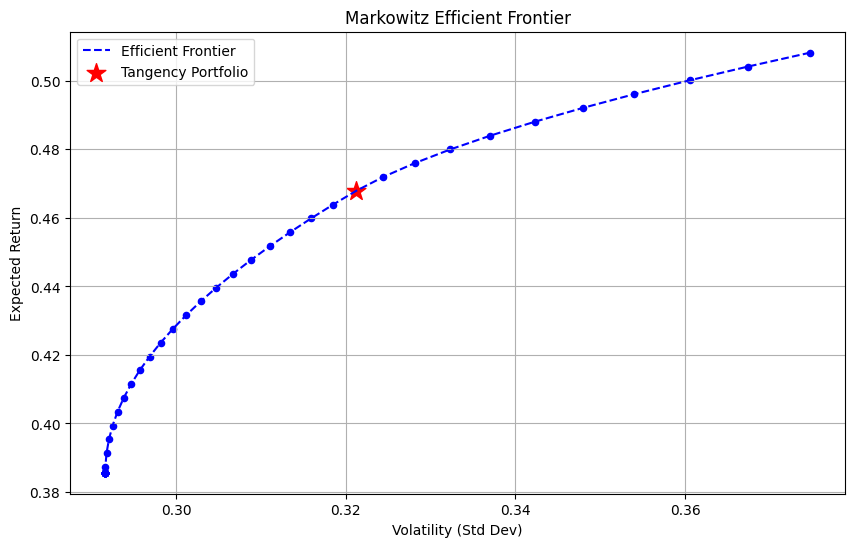

Tangency Portfolio Weights (Max Sharpe):
AAPL: 0.5040
MSFT: 0.0000
GOOGL: 0.4960
AMZN: 0.0000
META: 0.0000

Expected Annual Return: 0.4679
Expected Annual Risk (Volatility): 0.3212
Sharpe Ratio: 1.3943


In [1]:
# Install dependencies
!pip install yfinance cvxpy

# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Download stock price data
# -------------------------------
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META"]
data = yf.download(tickers, start="2020-01-01", end="2022-01-01")["Close"]

# Step 2: Calculate daily returns
returns = data.pct_change().dropna()

# Step 3: Annualized mean returns & covariance matrix
mu = returns.mean().values * 252        # annual expected returns
Sigma = returns.cov().values * 252      # annual covariance
n = len(tickers)

# -------------------------------
# Step 4: Efficient Frontier Setup
# -------------------------------
def solve_markowitz(target_return):
    w = cp.Variable(n)
    portfolio_return = mu @ w
    portfolio_risk = cp.quad_form(w, Sigma)
    prob = cp.Problem(cp.Minimize(portfolio_risk),
                      [cp.sum(w) == 1, w >= 0, portfolio_return >= target_return])
    prob.solve()
    if prob.status == "optimal":
        return w.value, portfolio_return.value, portfolio_risk.value
    else:
        return None, None, None

# Generate efficient frontier
target_returns = np.linspace(min(mu), max(mu), 50)
risks, rets, weights = [], [], []

for r in target_returns:
    w_opt, pret, prisk = solve_markowitz(r)
    if w_opt is not None:
        risks.append(np.sqrt(prisk))  # volatility = sqrt(variance)
        rets.append(pret)
        weights.append(w_opt)

# -------------------------------
# Step 5: Tangency Portfolio (Max Sharpe)
# -------------------------------
rf = 0.02  # risk-free rate (2%)
sharpe_ratios = [(r - rf)/s if s>0 else -1 for r, s in zip(rets, risks)]
max_idx = np.argmax(sharpe_ratios)

tangency_weights = weights[max_idx]
tangency_return = rets[max_idx]
tangency_risk = risks[max_idx]

# -------------------------------
# Step 6: Visualization
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(risks, rets, "b--", label="Efficient Frontier")
plt.scatter(risks, rets, c="blue", s=20)

# Tangency portfolio highlight
plt.scatter(tangency_risk, tangency_return, c="red", marker="*", s=200, label="Tangency Portfolio")

plt.xlabel("Volatility (Std Dev)")
plt.ylabel("Expected Return")
plt.title("Markowitz Efficient Frontier")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Step 7: Show Tangency Portfolio Weights
# -------------------------------
print("Tangency Portfolio Weights (Max Sharpe):")
for i, t in enumerate(tickers):
    print(f"{t}: {tangency_weights[i]:.4f}")

print("\nExpected Annual Return:", round(tangency_return,4))
print("Expected Annual Risk (Volatility):", round(tangency_risk,4))
print("Sharpe Ratio:", round(sharpe_ratios[max_idx],4))
